# Chargement des données 

In [1]:
from pyhive import hive
import pandas as pd
from IPython.display import display

1. Paramètres de connexion Hive 

In [2]:
hive_host = 'localhost'
hive_port = 10000
hive_username = ' ' 
hive_password = ' '

In [3]:
#conn = None
try:
    # Établir une connexion avec authentification LDAP
    conn = hive.Connection(
        host=hive_host,
        port=hive_port,
        username=hive_username,
        password=hive_password,
        auth='LDAP'  
    )
    print("Connecté à Hive avec succès")
except Exception as e:
    print(f"Erreur lors de la connexion à Hive: {e}")

Connecté à Hive avec succès


2. Chargement de données

In [4]:
# Créer un curseur
cursor=conn.cursor()

In [5]:
def findAll(table) :
    # Exécuter une requête pour récupérer les données de la table "catalogue"
    query = "SELECT * FROM " + table
    cursor.execute(query)

    # Charger les résultats dans un DataFrame Pandas
    data = cursor.fetchall()

    # Récupérer les noms des colonnes
    columns = [desc[0] for desc in cursor.description] 
    df = pd.DataFrame(data, columns=columns)
    print("Select all ",table)

    display(df.head())
    
    return df

    - Catalogue

In [7]:
df_catalogue = findAll("catalogue_co2_view")

Select all  catalogue_co2_view


,catalogue_co2_view.id,catalogue_co2_view.nom,catalogue_co2_view.puissance,catalogue_co2_view.longueur,catalogue_co2_view.nbplaces,catalogue_co2_view.nbportes,catalogue_co2_view.couleur,catalogue_co2_view.occasion,catalogue_co2_view.prix,catalogue_co2_view.marque,catalogue_co2_view.bonusmalus,catalogue_co2_view.rejetco2,catalogue_co2_view.coutenergie
0,1,S80 T6,272,3,5,5,blanc,0,50500,Volvo,0.0,42,72.72727
1,2,S80 T6,272,3,5,5,noir,0,50500,Volvo,0.0,42,72.72727
2,3,S80 T6,272,3,5,5,rouge,0,50500,Volvo,0.0,42,72.72727
3,4,S80 T6,272,3,5,5,gris,1,35350,Volvo,0.0,42,72.72727
4,5,S80 T6,272,3,5,5,bleu,1,35350,Volvo,0.0,42,72.72727


    - Immatriculation

In [8]:
df_immatriculation = findAll("immatriculation_co2_view")

Select all  immatriculation_co2_view


,immatriculation_co2_view.immatriculation,immatriculation_co2_view.marque,immatriculation_co2_view.nom,immatriculation_co2_view.puissance,immatriculation_co2_view.longueur,immatriculation_co2_view.nbplaces,immatriculation_co2_view.nbportes,immatriculation_co2_view.couleur,immatriculation_co2_view.occasion,immatriculation_co2_view.prix,immatriculation_co2_view.bonusmalus,immatriculation_co2_view.rejetco2,immatriculation_co2_view.coutenergie
0,3176 TS 67,Renault,Laguna 2.0T,170,2,5,5,blanc,0,27300,-6000.000000,0.0,206.000000
1,3721 QS 49,Volvo,S80 T6,272,3,5,5,noir,0,50500,0.000000,42.0,72.727272
2,9099 UV 26,Volkswagen,Golf 2.0 FSI,150,1,5,5,gris,1,16029,-1714.285767,23.0,96.000000
3,3563 LA 55,Peugeot,1007 1.4,75,0,5,5,blanc,1,9625,-3000.000000,15.0,144.166672
4,6963 AX 34,Audi,A2 1.4,75,0,5,5,gris,0,18310,-2400.000000,26.0,191.600006


    - Marketing 

In [9]:
df_marketing = findAll("marketing_view")

Select all  marketing_view


,marketing_view.id,marketing_view.age,marketing_view.sexe,marketing_view.taux,marketing_view.situationfamiliale,marketing_view.nbenfantsacharge,marketing_view.deuxiemevoiture
0,17,58,M,1192,EN_COUPLE,0,0
1,1,21,F,1396,CELIBATAIRE,0,0
2,15,60,M,524,EN_COUPLE,0,1
3,4,26,F,420,EN_COUPLE,3,1
4,7,59,F,572,EN_COUPLE,2,0


    - Client

In [10]:
df_client = findAll("client_view")

Select all  client_view


,client_view.id,client_view.age,client_view.sexe,client_view.taux,client_view.situationfamiliale,client_view.nbenfantsacharge,client_view.deuxiemevoiture,client_view.immatriculation
0,34,18,M,461,EN_COUPLE,4,0,4164 SS 15
1,43,30,M,243,EN_COUPLE,2,0,2663 KL 54
2,59,79,M,404,EN_COUPLE,2,0,1 BB 28
3,63,44,M,925,EN_COUPLE,0,0,3225 EV 17
4,75,70,M,458,CELIBATAIRE,0,0,4570 UR 19


# 1. ANALYSE EXPLORATOIRE DES DONNEES

## Statistiques descriptives / vérification des valeurs

In [11]:
def descriptionDataframe(table, df) :
    # Affichage des statistiques descriptives
    print("Affichage des statistiques descriptives de ", table)
    display(df.describe())
    
    # Affichage des types de données et des valeurs manquantes
    print("Affichage des types de données et des valeurs manquantes  de ", table)
    display(df.info())

    # Vérification des valeurs manquantes
    print("Vérification des valeurs manquantes  de ", table)
    display(df.isnull().sum())
    
    # Vérification des doublons
    print("Vérification des doublons  de ", table)
    duplicates = df.duplicated()
    print(f"Nombre de doublons : {duplicates.sum()}")

In [12]:
descriptionDataframe("Catalogue",df_catalogue)
#dfCatalogue.isnull().sum()

Affichage des statistiques descriptives de  Catalogue


,catalogue_co2_view.puissance,catalogue_co2_view.longueur,catalogue_co2_view.nbplaces,catalogue_co2_view.nbportes,catalogue_co2_view.occasion,catalogue_co2_view.prix,catalogue_co2_view.bonusmalus,catalogue_co2_view.rejetco2,catalogue_co2_view.coutenergie
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,157.592593,1.481481,5.222222,4.814815,0.407407,26668.055556,187.431646,68.462963,324.508324
std,90.551289,1.033648,0.629707,0.580798,0.492264,19050.121112,4731.591803,69.462812,248.393444
min,55.000000,0.000000,5.000000,3.000000,0.000000,7500.000000,-6000.000000,0.000000,72.727270
25%,109.000000,1.000000,5.000000,5.000000,0.000000,16029.000000,-3000.000000,15.000000,96.000000
50%,147.000000,2.000000,5.000000,5.000000,0.000000,20597.500000,-1714.285800,26.000000,206.000000
75%,170.000000,2.000000,5.000000,5.000000,1.000000,30000.000000,5671.586000,152.000000,611.673500
max,507.000000,3.000000,7.000000,5.000000,1.000000,101300.000000,7790.586400,187.000000,749.979700


Affichage des types de données et des valeurs manquantes  de  Catalogue
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   catalogue_co2_view.id           270 non-null    object 
 1   catalogue_co2_view.nom          270 non-null    object 
 2   catalogue_co2_view.puissance    270 non-null    int64  
 3   catalogue_co2_view.longueur     270 non-null    int64  
 4   catalogue_co2_view.nbplaces     270 non-null    int64  
 5   catalogue_co2_view.nbportes     270 non-null    int64  
 6   catalogue_co2_view.couleur      270 non-null    object 
 7   catalogue_co2_view.occasion     270 non-null    int64  
 8   catalogue_co2_view.prix         270 non-null    int64  
 9   catalogue_co2_view.marque       270 non-null    object 
 10  catalogue_co2_view.bonusmalus   270 non-null    float64
 11  catalogue_co2_view.rejetc

None

Vérification des valeurs manquantes  de  Catalogue


catalogue_co2_view.id             0
catalogue_co2_view.nom            0
catalogue_co2_view.puissance      0
catalogue_co2_view.longueur       0
catalogue_co2_view.nbplaces       0
catalogue_co2_view.nbportes       0
catalogue_co2_view.couleur        0
catalogue_co2_view.occasion       0
catalogue_co2_view.prix           0
catalogue_co2_view.marque         0
catalogue_co2_view.bonusmalus     0
catalogue_co2_view.rejetco2       0
catalogue_co2_view.coutenergie    0
dtype: int64

Vérification des doublons  de  Catalogue
Nombre de doublons : 0


In [13]:
descriptionDataframe("Immatriculation",df_immatriculation)

Affichage des statistiques descriptives de  Immatriculation


,immatriculation_co2_view.puissance,immatriculation_co2_view.longueur,immatriculation_co2_view.nbplaces,immatriculation_co2_view.nbportes,immatriculation_co2_view.occasion,immatriculation_co2_view.prix,immatriculation_co2_view.bonusmalus,immatriculation_co2_view.rejetco2,immatriculation_co2_view.coutenergie
count,2.000000e+06,2.000000e+06,2000000.0,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06
mean,1.990422e+02,1.671633e+00,5.0,4.868432e+00,3.127450e-01,3.578257e+04,-4.675910e+02,5.824283e+01,2.882441e+02
std,1.371486e+02,1.201701e+00,0.0,4.958084e-01,4.636116e-01,2.577564e+04,4.492288e+03,6.449235e+01,2.317530e+02
min,5.500000e+01,0.000000e+00,5.0,3.000000e+00,0.000000e+00,7.500000e+03,-6.000000e+03,0.000000e+00,7.272727e+01
25%,7.500000e+01,0.000000e+00,5.0,5.000000e+00,0.000000e+00,1.831000e+04,-3.000000e+03,1.500000e+01,9.600000e+01
50%,1.500000e+02,2.000000e+00,5.0,5.000000e+00,0.000000e+00,2.597000e+04,-1.714286e+03,2.600000e+01,1.916000e+02
75%,2.450000e+02,3.000000e+00,5.0,5.000000e+00,1.000000e+00,4.920000e+04,5.671586e+03,1.520000e+02,6.116735e+02
max,5.070000e+02,3.000000e+00,5.0,5.000000e+00,1.000000e+00,1.013000e+05,7.790586e+03,1.870000e+02,7.499797e+02


Affichage des types de données et des valeurs manquantes  de  Immatriculation
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 13 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   immatriculation_co2_view.immatriculation  object 
 1   immatriculation_co2_view.marque           object 
 2   immatriculation_co2_view.nom              object 
 3   immatriculation_co2_view.puissance        int64  
 4   immatriculation_co2_view.longueur         int64  
 5   immatriculation_co2_view.nbplaces         int64  
 6   immatriculation_co2_view.nbportes         int64  
 7   immatriculation_co2_view.couleur          object 
 8   immatriculation_co2_view.occasion         int64  
 9   immatriculation_co2_view.prix             int64  
 10  immatriculation_co2_view.bonusmalus       float64
 11  immatriculation_co2_view.rejetco2         float64
 12  immatriculation_co2_view.coutenerg

None

Vérification des valeurs manquantes  de  Immatriculation


immatriculation_co2_view.immatriculation    0
immatriculation_co2_view.marque             0
immatriculation_co2_view.nom                0
immatriculation_co2_view.puissance          0
immatriculation_co2_view.longueur           0
immatriculation_co2_view.nbplaces           0
immatriculation_co2_view.nbportes           0
immatriculation_co2_view.couleur            0
immatriculation_co2_view.occasion           0
immatriculation_co2_view.prix               0
immatriculation_co2_view.bonusmalus         0
immatriculation_co2_view.rejetco2           0
immatriculation_co2_view.coutenergie        0
dtype: int64

Vérification des doublons  de  Immatriculation
Nombre de doublons : 24


In [14]:
# Suppression des doublons
df_immatriculation.drop_duplicates(inplace=True)
print(f"Nombre de doublons après suppression : {df_immatriculation.duplicated().sum()}")

Nombre de doublons après suppression : 0


In [15]:
descriptionDataframe("Client",df_client)

Affichage des statistiques descriptives de  Client


,client_view.id,client_view.age,client_view.taux,client_view.nbenfantsacharge,client_view.deuxiemevoiture
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,43.548120,607.935360,1.250440,0.129530
std,28867.657797,18.458569,337.521466,1.388877,0.335787
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25000.750000,27.000000,420.000000,0.000000,0.000000
50%,50000.500000,41.000000,521.000000,1.000000,0.000000
75%,75000.250000,56.000000,830.000000,2.000000,0.000000
max,100000.000000,84.000000,1399.000000,4.000000,1.000000


Affichage des types de données et des valeurs manquantes  de  Client
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   client_view.id                  100000 non-null  int64 
 1   client_view.age                 100000 non-null  int64 
 2   client_view.sexe                100000 non-null  object
 3   client_view.taux                100000 non-null  int64 
 4   client_view.situationfamiliale  100000 non-null  object
 5   client_view.nbenfantsacharge    100000 non-null  int64 
 6   client_view.deuxiemevoiture     100000 non-null  int64 
 7   client_view.immatriculation     100000 non-null  object
dtypes: int64(5), object(3)
memory usage: 6.1+ MB


None

Vérification des valeurs manquantes  de  Client


client_view.id                    0
client_view.age                   0
client_view.sexe                  0
client_view.taux                  0
client_view.situationfamiliale    0
client_view.nbenfantsacharge      0
client_view.deuxiemevoiture       0
client_view.immatriculation       0
dtype: int64

Vérification des doublons  de  Client
Nombre de doublons : 0


In [16]:
descriptionDataframe("Marketing",df_marketing)

Affichage des statistiques descriptives de  Marketing


,marketing_view.id,marketing_view.age,marketing_view.taux,marketing_view.nbenfantsacharge,marketing_view.deuxiemevoiture
count,20.00000,20.000000,20.000000,20.000000,20.000000
mean,10.50000,45.000000,582.400000,0.950000,0.250000
std,5.91608,19.246326,345.656111,1.276302,0.444262
min,1.00000,19.000000,153.000000,0.000000,0.000000
25%,5.75000,26.750000,408.500000,0.000000,0.000000
50%,10.50000,45.500000,527.000000,0.000000,0.000000
75%,15.25000,59.000000,628.750000,2.000000,0.250000
max,20.00000,80.000000,1396.000000,3.000000,1.000000


Affichage des types de données et des valeurs manquantes  de  Marketing
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   marketing_view.id                  20 non-null     int64 
 1   marketing_view.age                 20 non-null     int64 
 2   marketing_view.sexe                20 non-null     object
 3   marketing_view.taux                20 non-null     int64 
 4   marketing_view.situationfamiliale  20 non-null     object
 5   marketing_view.nbenfantsacharge    20 non-null     int64 
 6   marketing_view.deuxiemevoiture     20 non-null     int64 
dtypes: int64(5), object(2)
memory usage: 1.2+ KB


None

Vérification des valeurs manquantes  de  Marketing


marketing_view.id                    0
marketing_view.age                   0
marketing_view.sexe                  0
marketing_view.taux                  0
marketing_view.situationfamiliale    0
marketing_view.nbenfantsacharge      0
marketing_view.deuxiemevoiture       0
dtype: int64

Vérification des doublons  de  Marketing
Nombre de doublons : 0


## Matrice de corrélation

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib created a temporary cache directory at /tmp/matplotlib-4e_apqmr because the default path (/home/vagrant/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


,catalogue_co2_view.puissance,catalogue_co2_view.nbplaces,catalogue_co2_view.nbportes,catalogue_co2_view.prix,catalogue_co2_view.longueur,catalogue_co2_view.bonusmalus,catalogue_co2_view.rejetco2,catalogue_co2_view.coutenergie
catalogue_co2_view.puissance,1.000000,-0.057082,0.310988,0.875451,0.737272,-0.030465,-0.046912,-0.112639
catalogue_co2_view.nbplaces,-0.057082,1.000000,0.112938,-0.081890,0.177686,-0.185674,-0.174036,-0.137936
catalogue_co2_view.nbportes,0.310988,0.112938,1.000000,0.271480,0.458687,-0.171109,-0.147141,-0.104227
catalogue_co2_view.prix,0.875451,-0.081890,0.271480,1.000000,0.677685,0.103902,0.091605,0.031388
catalogue_co2_view.longueur,0.737272,0.177686,0.458687,0.677685,1.000000,0.094991,0.119074,0.125623
catalogue_co2_view.bonusmalus,-0.030465,-0.185674,-0.171109,0.103902,0.094991,1.000000,0.978089,0.856438
catalogue_co2_view.rejetco2,-0.046912,-0.174036,-0.147141,0.091605,0.119074,0.978089,1.000000,0.942914
catalogue_co2_view.coutenergie,-0.112639,-0.137936,-0.104227,0.031388,0.125623,0.856438,0.942914,1.000000


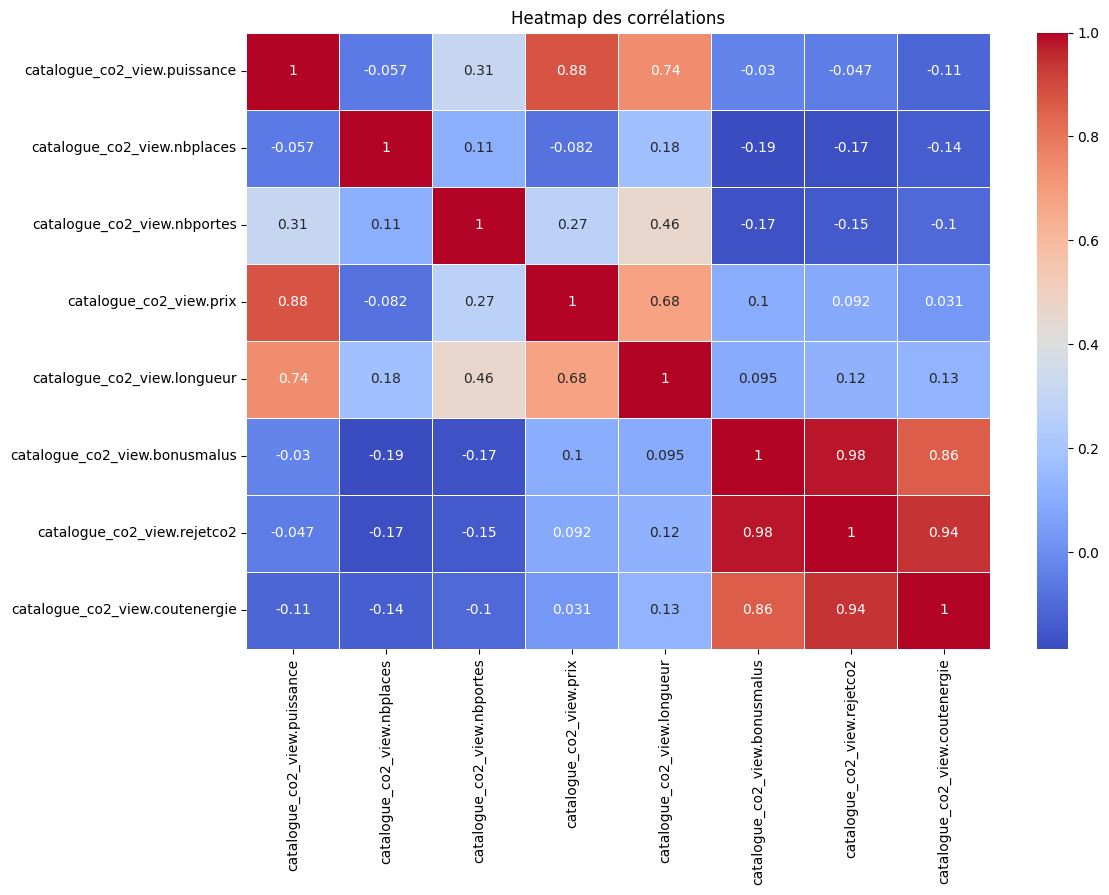

In [18]:
# Exclure les colonnes non numériques spécifiées
df = df_catalogue.copy()

# Calcul de la matrice de corrélation
corr_matrix = df[[
    'catalogue_co2_view.puissance', 
    'catalogue_co2_view.nbplaces', 
    'catalogue_co2_view.nbportes', 
    'catalogue_co2_view.prix', 
    'catalogue_co2_view.longueur',
    'catalogue_co2_view.bonusmalus',
    'catalogue_co2_view.rejetco2',
    'catalogue_co2_view.coutenergie'
]].corr()
display(corr_matrix)

# Visualisation de la matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap des corrélations')
plt.show()


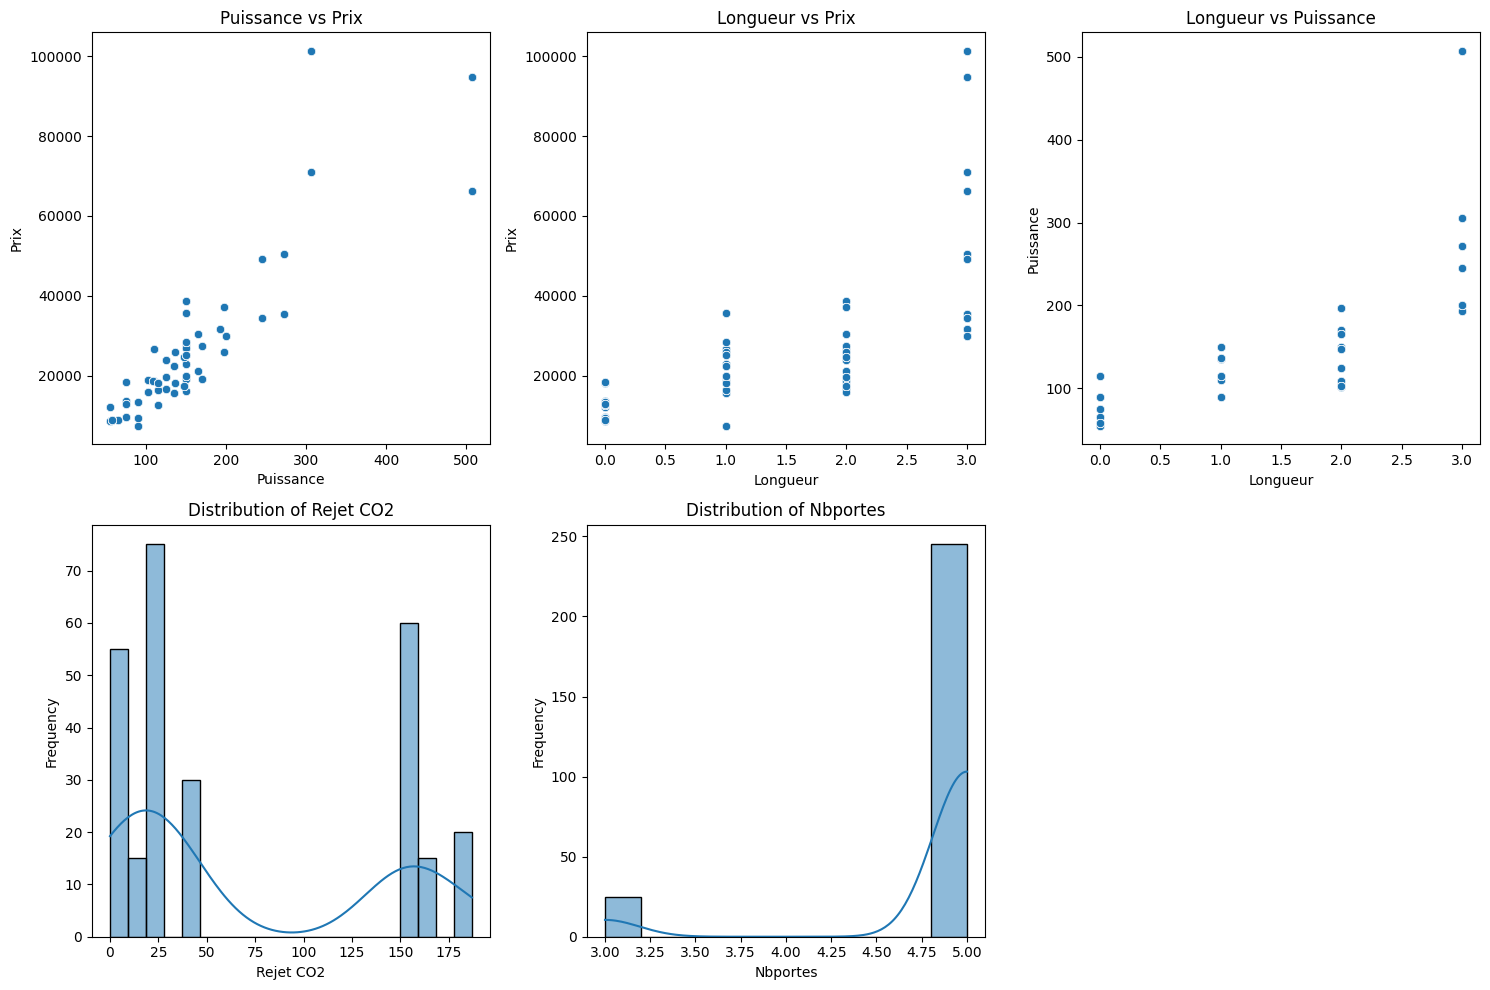

In [20]:
# Scatter plot of puissance vs prix
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
sns.scatterplot(data=df, x='catalogue_co2_view.puissance', y='catalogue_co2_view.prix')
plt.title('Puissance vs Prix')
plt.xlabel('Puissance')
plt.ylabel('Prix')

# Scatter plot of longueur vs prix
plt.subplot(2, 3, 2)
sns.scatterplot(data=df, x='catalogue_co2_view.longueur', y='catalogue_co2_view.prix')
plt.title('Longueur vs Prix')
plt.xlabel('Longueur')
plt.ylabel('Prix')

# Scatter plot of longueur vs puissance
plt.subplot(2, 3, 3)
sns.scatterplot(data=df, x='catalogue_co2_view.longueur', y='catalogue_co2_view.puissance')
plt.title('Longueur vs Puissance')
plt.xlabel('Longueur')
plt.ylabel('Puissance')

# Histogram of rejetco2
plt.subplot(2, 3, 4)
sns.histplot(data=df, x='catalogue_co2_view.rejetco2', bins=20, kde=True)
plt.title('Distribution of Rejet CO2')
plt.xlabel('Rejet CO2')
plt.ylabel('Frequency')

# Histogram of nbportes
plt.subplot(2, 3, 5)
sns.histplot(data=df, x='catalogue_co2_view.nbportes', bins=10, kde=True)
plt.title('Distribution of Nbportes')
plt.xlabel('Nbportes')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Conclusion:

1. **Variables importantes :**
- Puissance, prix et longueur : Ces variables montrent de fortes corrélations avec plusieurs autres variables. Elle sont cruciales pour distinguer les différentes catégories de véhicules. 
- Nombre de places: Elle ne présente de forte corrélations avec aucune variable en particulier donc ne doit pas être exclue car elle présente un impact potentiel à faire varier le clustering.
- Rejet de CO2, bonus et coût d'énergie :  Elles sont fortement corrélées entre elles mais ne montrent pas de forte corrélation avec les autres variables  mis à part longueur et prix qui seront déjà considérées dans le cluster donc on va considérer une seules de ces variables pour éviter la redondance, ici on a choisi la variable rejetco2.

2. **Variables moins pertinentes :**
- Nombre de portes : Cette variable présente une distribution homogène et peut être moins informative pour le clu
  stering.
3. **Variables à considérer pour le clustering :**
- Puissance, nombre de places, prix, longueur,rejetco2 : Ces variables ont donc été identifiées comme les plus pertinentes pour effectuer le clustering des véhicules.véhicules.les.

# 2. Categorisation des véhicules

In [31]:
col_predictive = [
    'catalogue_co2_view.puissance', 
    'catalogue_co2_view.nbplaces', 
    'catalogue_co2_view.prix', 
    'catalogue_co2_view.longueur',
    'catalogue_co2_view.rejetco2'
]

In [32]:
# Sélectionner les caractéristiques pertinentes
df_catalogue_used = df_catalogue[col_predictive]
df_catalogue_used.head(5)

,catalogue_co2_view.puissance,catalogue_co2_view.nbplaces,catalogue_co2_view.prix,catalogue_co2_view.longueur,catalogue_co2_view.rejetco2
0,272,5,50500,3,42
1,272,5,50500,3,42
2,272,5,50500,3,42
3,272,5,35350,3,42
4,272,5,35350,3,42


In [33]:
from sklearn.preprocessing import StandardScaler

# Normalisation des données
scaler = StandardScaler()
scaled_df_catalogue_used = scaler.fit_transform(df_catalogue_used)
print("done")

done


In [34]:
#remettre en dataframe le tableau numpy des données catalogué mise à l'echelle pour vérifier
scaled_df_catalogue_used_to_df = pd.DataFrame(scaled_df_catalogue_used, columns=df_catalogue_used.columns)
print("done")

display(scaled_df_catalogue_used_to_df.head())

done


,catalogue_co2_view.puissance,catalogue_co2_view.nbplaces,catalogue_co2_view.prix,catalogue_co2_view.longueur,catalogue_co2_view.rejetco2
0,1.2658,-0.353553,1.253336,1.471814,-0.381673
1,1.2658,-0.353553,1.253336,1.471814,-0.381673
2,1.2658,-0.353553,1.253336,1.471814,-0.381673
3,1.2658,-0.353553,0.456589,1.471814,-0.381673
4,1.2658,-0.353553,0.456589,1.471814,-0.381673


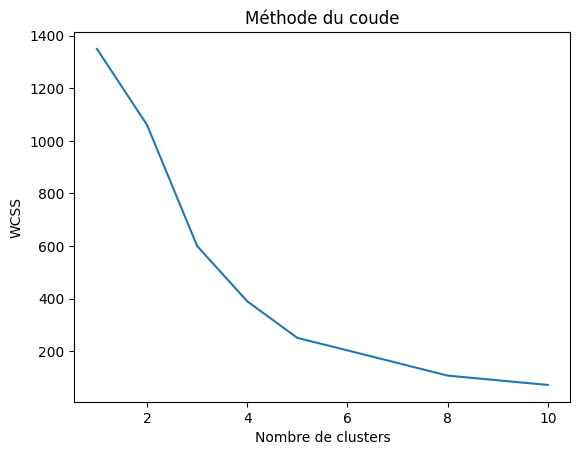

In [35]:
from sklearn.cluster import KMeans

# Utiliser la méthode du coude pour trouver le nombre optimal de clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_df_catalogue_used)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')
plt.show()


D'après la methode de coude, on voit ici que le nombre optimale de cluster est aux alentours de 4

In [36]:
# Application de k-means avec le nombre de clusters choisi
kmeans = KMeans(n_clusters=4, random_state=42)
df_catalogue['catalogue_co2_view.cluster'] = kmeans.fit_predict(scaled_df_catalogue_used)
print("done")

done


In [37]:
# Calculer les caractéristiques moyennes de chaque cluster
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_labels = df_catalogue['catalogue_co2_view.cluster'].unique()
cluster_summary = pd.DataFrame(cluster_centers, columns=df_catalogue_used.columns, index=cluster_labels)

display(cluster_summary)

,catalogue_co2_view.puissance,catalogue_co2_view.nbplaces,catalogue_co2_view.prix,catalogue_co2_view.longueur,catalogue_co2_view.rejetco2
2,143.000,7.0,22263.833333,2.000000,34.333333
0,123.000,5.0,19832.869565,0.782609,17.478261
1,317.000,5.0,59405.555556,3.000000,62.555556
3,123.125,5.0,19730.375000,1.437500,157.875000


In [38]:
cluster_labels = {
    0: 'Citadine',
    1: 'Luxe',
    2: 'Compacte',
    3: 'Familiale'
}
df_catalogue['catalogue_co2_view.categorie'] = df_catalogue['catalogue_co2_view.cluster'].map(cluster_labels)

# Afficher le catalogue avec les catégories assignées
df_catalogue.head()

,catalogue_co2_view.id,catalogue_co2_view.nom,catalogue_co2_view.puissance,catalogue_co2_view.longueur,catalogue_co2_view.nbplaces,catalogue_co2_view.nbportes,catalogue_co2_view.couleur,catalogue_co2_view.occasion,catalogue_co2_view.prix,catalogue_co2_view.marque,catalogue_co2_view.bonusmalus,catalogue_co2_view.rejetco2,catalogue_co2_view.coutenergie,catalogue_co2_view.cluster,catalogue_co2_view.categorie
0,1,S80 T6,272,3,5,5,blanc,0,50500,Volvo,0.0,42,72.72727,2,Compacte
1,2,S80 T6,272,3,5,5,noir,0,50500,Volvo,0.0,42,72.72727,2,Compacte
2,3,S80 T6,272,3,5,5,rouge,0,50500,Volvo,0.0,42,72.72727,2,Compacte
3,4,S80 T6,272,3,5,5,gris,1,35350,Volvo,0.0,42,72.72727,2,Compacte
4,5,S80 T6,272,3,5,5,bleu,1,35350,Volvo,0.0,42,72.72727,2,Compacte


# 3. Application des catégories de véhicules définies aux données des Immatriculations

In [39]:
df_immatriculation.head()

,immatriculation_co2_view.immatriculation,immatriculation_co2_view.marque,immatriculation_co2_view.nom,immatriculation_co2_view.puissance,immatriculation_co2_view.longueur,immatriculation_co2_view.nbplaces,immatriculation_co2_view.nbportes,immatriculation_co2_view.couleur,immatriculation_co2_view.occasion,immatriculation_co2_view.prix,immatriculation_co2_view.bonusmalus,immatriculation_co2_view.rejetco2,immatriculation_co2_view.coutenergie
0,3176 TS 67,Renault,Laguna 2.0T,170,2,5,5,blanc,0,27300,-6000.000000,0.0,206.000000
1,3721 QS 49,Volvo,S80 T6,272,3,5,5,noir,0,50500,0.000000,42.0,72.727272
2,9099 UV 26,Volkswagen,Golf 2.0 FSI,150,1,5,5,gris,1,16029,-1714.285767,23.0,96.000000
3,3563 LA 55,Peugeot,1007 1.4,75,0,5,5,blanc,1,9625,-3000.000000,15.0,144.166672
4,6963 AX 34,Audi,A2 1.4,75,0,5,5,gris,0,18310,-2400.000000,26.0,191.600006


In [40]:
col_predictive_immatriculation = [
    'immatriculation_co2_view.puissance', 
    'immatriculation_co2_view.longueur', 
    'immatriculation_co2_view.nbplaces', 
    'immatriculation_co2_view.prix',
    'immatriculation_co2_view.rejetco2'
]

In [41]:
# Sélectionner les caractéristiques pertinentes pour les immatriculations
df_immatriculation_used = df_immatriculation[col_predictive_immatriculation]

df_immatriculation_used.head()

,immatriculation_co2_view.puissance,immatriculation_co2_view.longueur,immatriculation_co2_view.nbplaces,immatriculation_co2_view.prix,immatriculation_co2_view.rejetco2
0,170,2,5,27300,0.0
1,272,3,5,50500,42.0
2,150,1,5,16029,23.0
3,75,0,5,9625,15.0
4,75,0,5,18310,26.0


In [42]:
# Normalisation des données
scalerImma = StandardScaler()
scaled_df_immatriculation_used = scalerImma.fit_transform(df_immatriculation_used)
print("done scaling")

done scaling


In [43]:
# Utiliser le modèle de clustering pour prédire les clusters des données d'immatriculation
df_immatriculation['immatriculation_co2_view.cluster'] = kmeans.predict(scaled_df_immatriculation_used)

# Mapper les clusters prédits aux catégories de véhicules correspondantes
cluster_labels = {
    0: 'Citadine',
    1: 'Luxe',
    2: 'Compacte',
    3: 'Familiale'
}
df_immatriculation['immatriculation_co2_view.categorie'] = df_immatriculation['immatriculation_co2_view.cluster'].map(cluster_labels)
print("done")

# Afficher le DataFrame d'immatriculation avec les catégories assignées
df_immatriculation.head()


done


,immatriculation_co2_view.immatriculation,immatriculation_co2_view.marque,immatriculation_co2_view.nom,immatriculation_co2_view.puissance,immatriculation_co2_view.longueur,immatriculation_co2_view.nbplaces,immatriculation_co2_view.nbportes,immatriculation_co2_view.couleur,immatriculation_co2_view.occasion,immatriculation_co2_view.prix,immatriculation_co2_view.bonusmalus,immatriculation_co2_view.rejetco2,immatriculation_co2_view.coutenergie,immatriculation_co2_view.cluster,immatriculation_co2_view.categorie
0,3176 TS 67,Renault,Laguna 2.0T,170,2,5,5,blanc,0,27300,-6000.000000,0.0,206.000000,1,Luxe
1,3721 QS 49,Volvo,S80 T6,272,3,5,5,noir,0,50500,0.000000,42.0,72.727272,0,Citadine
2,9099 UV 26,Volkswagen,Golf 2.0 FSI,150,1,5,5,gris,1,16029,-1714.285767,23.0,96.000000,1,Luxe
3,3563 LA 55,Peugeot,1007 1.4,75,0,5,5,blanc,1,9625,-3000.000000,15.0,144.166672,1,Luxe
4,6963 AX 34,Audi,A2 1.4,75,0,5,5,gris,0,18310,-2400.000000,26.0,191.600006,1,Luxe


# 4. Fusion des données Clients et Immatriculations

In [44]:
# Fusionner les deux DataFrames sur la colonne 'immatriculation'
df_fusion = pd.merge(df_client, df_immatriculation, how='inner', left_on='client_view.immatriculation', right_on='immatriculation_co2_view.immatriculation')
print("Fusion done")

# Afficher les premières lignes du DataFrame fusionné
df_fusion.head()

Fusion done


,client_view.id,client_view.age,client_view.sexe,client_view.taux,client_view.situationfamiliale,client_view.nbenfantsacharge,client_view.deuxiemevoiture,client_view.immatriculation,immatriculation_co2_view.immatriculation,immatriculation_co2_view.marque,...,immatriculation_co2_view.nbplaces,immatriculation_co2_view.nbportes,immatriculation_co2_view.couleur,immatriculation_co2_view.occasion,immatriculation_co2_view.prix,immatriculation_co2_view.bonusmalus,immatriculation_co2_view.rejetco2,immatriculation_co2_view.coutenergie,immatriculation_co2_view.cluster,immatriculation_co2_view.categorie
0,34,18,M,461,EN_COUPLE,4,0,4164 SS 15,4164 SS 15,BMW,...,5,5,noir,1,66360,-631.578918,39.0,80.526314,2,Compacte
1,43,30,M,243,EN_COUPLE,2,0,2663 KL 54,2663 KL 54,Renault,...,5,5,bleu,1,34440,-6000.000000,0.0,206.000000,1,Luxe
2,59,79,M,404,EN_COUPLE,2,0,1 BB 28,1 BB 28,Saab,...,5,5,bleu,1,27020,5671.585938,152.0,611.673523,3,Familiale
3,63,44,M,925,EN_COUPLE,0,0,3225 EV 17,3225 EV 17,Jaguar,...,5,5,rouge,0,37100,-6000.000000,0.0,271.000000,1,Luxe
4,75,70,M,458,CELIBATAIRE,0,0,4570 UR 19,4570 UR 19,Volkswagen,...,5,3,blanc,0,12200,-1714.285767,23.0,96.000000,1,Luxe


In [45]:
columns_to_drop = ["immatriculation_co2_view.immatriculation", "immatriculation_co2_view.marque", "immatriculation_co2_view.nom",
                   "immatriculation_co2_view.puissance", "immatriculation_co2_view.longueur", "immatriculation_co2_view.nbplaces",
                   "immatriculation_co2_view.nbportes", "immatriculation_co2_view.couleur", "immatriculation_co2_view.occasion",
                   "immatriculation_co2_view.prix", "immatriculation_co2_view.cluster", "immatriculation_co2_view.rejetco2",
                   "immatriculation_co2_view.bonusmalus", "immatriculation_co2_view.coutenergie", "client_view.immatriculation"]

df_fusion_new = df_fusion.drop(columns=columns_to_drop)

In [46]:
df_fusion_new.head()

,client_view.id,client_view.age,client_view.sexe,client_view.taux,client_view.situationfamiliale,client_view.nbenfantsacharge,client_view.deuxiemevoiture,immatriculation_co2_view.categorie
0,34,18,M,461,EN_COUPLE,4,0,Compacte
1,43,30,M,243,EN_COUPLE,2,0,Luxe
2,59,79,M,404,EN_COUPLE,2,0,Familiale
3,63,44,M,925,EN_COUPLE,0,0,Luxe
4,75,70,M,458,CELIBATAIRE,0,0,Luxe


### Mettre les données de fusion entre immatriculations et clients dans hdfs

In [47]:
df_fusion_new.to_csv('/vagrant/tpa_groupe_14/data/fusion.csv', index=False, encoding='utf-8')

In [48]:
!hadoop fs -mkdir -p /tpa_groupe_14/data/fusion

In [49]:
!hadoop fs -put -f /vagrant/tpa_groupe_14/data/fusion.csv /tpa_groupe_14/data/fusion

In [50]:
!hadoop fs -ls /tpa_groupe_14/data/fusion

Found 1 items
-rw-r--r--   1 vagrant supergroup    3700214 2024-06-09 12:55 /tpa_groupe_14/data/fusion/fusion.csv
